In [0]:
#!pip install tensorflow-gpu==2.0.0

In [0]:
################################################################################
# %% CONNECT TO DRIVE
################################################################################

from google.colab import drive, files
drive.mount('/content/drive')

In [0]:
################################################################################
# %% IMPORT PACKAGES
################################################################################

import os
import glob
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import sys
from time import time
import matplotlib.pyplot as mp
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, random_brightness, random_zoom, random_rotation
from scipy import ndimage

In [0]:
################################################################################
# %% LOAD DATA AND SPLIT INTO BATCHES
################################################################################

def generate_data(dpath, batch_size=128, tag='train', aug=None):

    ##### READ FOLDER CONTENTS
    fimg = sorted(glob.glob(dpath+f'image-{tag}*'))
    flbl = fimg
    flbl = [f.replace('image', 'label') for f in flbl] 

    ##### READ FIRST FILE TO BUFFER
    print(f'----> Reading {fimg[0]} <----')
    print(f'----> Reading {flbl[0]} <----')
    X_in = np.load(fimg[0])
    y_in = np.load(flbl[0])

    ##### SHUFFLE
    #idx = np.arange(len(X_in))
    #idx = np.random.shuffle(idx)
    idx = np.random.permutation(len(X_in))

    X_in = X_in[idx, :, :, :]
    y_in = y_in[idx, :, :, :]

    ##### START COUNTING
    i = 0
    
    ##### LOOP INDEFINITELY
    while True:

        ##### IF BUFFER NOT SUFFICIENT TO COVER NEXT BATCH
        if len(X_in) < batch_size:

            ##### SET NEXT INDEX BASED ON LENGHT OF FOLDER CONTENTS
            if i<len(fimg)-1:
                i += 1
            else:
                i = 0
            
            ##### APPEND NEXT FILE
            print(f'----> Reading {fimg[i]} <----')
            print(f'----> Reading {flbl[i]} <----')
            X_in = np.concatenate((X_in, np.load(fimg[i])), axis=0)
            y_in = np.concatenate((y_in, np.load(flbl[i])), axis=0)

            ##### SHUFFLE
            #idx = np.arange(len(X_in))
            #idx = np.random.shuffle(idx)
            idx = np.random.permutation(len(X_in))

            X_in = X_in[idx, :, :, :]
            y_in = y_in[idx, :, :, :]

        else:
            if aug:
                for idx in range(batch_size):
                    ##### RANDOM BRIGHTNESS VARIATION
                    X_in[idx] = random_brightness(X_in[idx],(1.0-aug,1.0+aug))
                    
                    ##### APPLY RANDOM UNIFORM BLUR
                    depth = int(round(np.random.random()*4)) # 4 for cars
                    X_in[idx] = ndimage.uniform_filter(X_in[idx], size=(depth, depth, 1))

                    ##### RANDOM ZOOM AUGMENTATION (DOESN'T INCLUDE TARGET!)
                    #X_in[idx] = random_zoom(X_in[idx],(1.0,1.2), row_axis=0, col_axis=1, channel_axis=2)

                    ##### APPLY RANDOM ROTATIONS (90DEG INCREMENTS, USE ONLY IF NOT AUGMENTED INPUT DATA)
                    #times = int(round(np.random.random()*3))
                    #X_in[idx] = np.rot90(X_in[idx], k=times, axes=(0, 1))
                    #y_in[idx] = np.rot90(y_in[idx], k=times, axes=(0, 1))

            ##### YIELD SET
            yield X_in[:batch_size, :, :, :], y_in[:batch_size, :, :, :]

            ##### REMOVE YIELDED RESULTS
            X_in = np.delete(X_in, range(batch_size), axis=0)
            y_in = np.delete(y_in, range(batch_size), axis=0)

##### INIT TRAINING DATA GENERATOR     
train_gen = generate_data('drive/My Drive/Data/road/', batch_size=1024, tag='train', aug=0.3)

##### INIT VALIDATION DATA GENERATOR
val_gen = generate_data('drive/My Drive/Data/road/', batch_size=1024, tag='val', aug=0.3)

In [0]:
################################################################################
# %% UNET MODEL
################################################################################

def unet_model(power=2):
  
  input_size = (256,256,3)

  inputs = Input(input_size)
  conv1 = Conv2D(2**(power), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(inputs)
  conv1 = BatchNormalization()(conv1)
  conv1 = Conv2D(2**(power), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv1)
  conv1 = BatchNormalization()(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(2**(power+1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(pool1)
  conv2 = BatchNormalization()(conv2)
  conv2 = Conv2D(2**(power+1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv2)
  conv2 = BatchNormalization()(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(2**(power+2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(pool2)
  conv3 = BatchNormalization()(conv3)
  conv3 = Conv2D(2**(power+2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv3)
  conv3 = BatchNormalization()(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  
  conv4 = Conv2D(2**(power+3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(pool3)
  conv4 = BatchNormalization()(conv4)
  conv4 = Conv2D(2**(power+3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv4)
  conv4 = BatchNormalization()(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(2**(power+4), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(pool4)
  conv5 = BatchNormalization()(conv5)
  conv5 = Conv2D(2**(power+4), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv5)
  conv5 = BatchNormalization()(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(2**(power+3), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(UpSampling2D(size = (2,2), interpolation='bilinear')(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(2**(power+3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(merge6)
  conv6 = BatchNormalization()(conv6)
  conv6 = Conv2D(2**(power+3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv6)
  conv6 = BatchNormalization()(conv6)

  up7 = Conv2D(2**(power+2), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(UpSampling2D(size = (2,2), interpolation='bilinear')(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(2**(power+2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(merge7)
  conv7 = BatchNormalization()(conv7)
  conv7 = Conv2D(2**(power+2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv7)
  conv7 = BatchNormalization()(conv7)

  up8 = Conv2D(2**(power+1), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(UpSampling2D(size = (2,2), interpolation='bilinear')(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(2**(power+1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(merge8)
  conv8 = BatchNormalization()(conv8)
  conv8 = Conv2D(2**(power+1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv8)
  conv8 = BatchNormalization()(conv8)

  up9 = Conv2D(2**(power), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(UpSampling2D(size = (2,2), interpolation='bilinear')(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(2**(power), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(merge9)
  conv9 = BatchNormalization()(conv9)
  conv9 = Conv2D(2**(power), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv9)
  conv9 = BatchNormalization()(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = keras.Model(inputs = inputs, outputs = conv10)
  return model

In [4]:
################################################################################
# %% BUILD UNET MODEL
################################################################################

model = unet_model(4)
model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D) 

In [0]:
################################################################################
# %% INIT CALLBACKS
################################################################################

#tensorboard = TensorBoard(log_dir='logs/{}'.format(time()), update_freq='epoch')
#earlystopping = EarlyStopping(monitor='loss', patience=100)
modelcheckpoint = ModelCheckpoint('drive/My Drive/Data/keras_model_checkpoint.h5', monitor='loss',verbose=1, save_best_only=True)#, save_freq='epoch')

In [37]:
%%time

################################################################################
# %% RUN MODEL
################################################################################

##### RESTART
#model = tf.keras.models.load_model('drive/My Drive/Data/keras_model_checkpoint.h5')
#model.load_weights("drive/My Drive/Data/keras_model.h5")

##### INIT HISTORY IF NOT RESTARTING
if 'loss' not in locals():
    loss = []
    acc = []
    val_loss = []
    val_acc = []

##### TRAIN
for iter in range(32):
    print(f'Outer iteration {iter}')

    ##### GEN NEXT DATA SETS FROM GENERATORS AND NORMALIZE
    X_train, y_train = next(train_gen)
    X_test, y_test = next(val_gen)
    X_train = X_train/255.0
    X_test = X_test/255.0

    ##### FIT MODEL ON CURRENT DATASET
    history = model.fit( 
        x = X_train,
        y = y_train,
        validation_data=(X_test, y_test),
        epochs=1,
        verbose=1,
        use_multiprocessing=True,
        #batch_size=16,
        callbacks=[modelcheckpoint] #tensorboard earlystopping, 
    )

    ##### APPEND METRICS TO HISTORY
    loss.append(history.history['loss'])
    acc.append(history.history['acc'])
    val_loss.append(history.history['val_loss'])
    val_acc.append(history.history['val_acc'])

    #### TEMP
    hist = pd.DataFrame()
    hist['loss'] = np.array(loss).flatten()
    hist['val_loss'] = np.array(val_loss).flatten()
    hist['acc'] = np.array(acc).flatten()
    hist['val_acc'] = np.array(val_acc).flatten()

    hist.to_csv('drive/My Drive/Data/hist1.csv')

##### SAVE UPON EXIT
model.save('drive/My Drive/Data/keras_model.h5')

Outer iteration 0
----> Reading drive/My Drive/Data/road/image-train-0.npy <----
----> Reading drive/My Drive/Data/road/label-train-0.npy <----
----> Reading drive/My Drive/Data/road/image-val-20.npy <----
----> Reading drive/My Drive/Data/road/label-val-20.npy <----
Train on 1024 samples, validate on 1024 samples
 992/1024 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9832
Epoch 00001: loss did not improve from 0.03002
1024/1024 [==============================] - 13s 13ms/sample - loss: 0.0426 - acc: 0.9834 - val_loss: 0.0887 - val_acc: 0.9683
Outer iteration 1
----> Reading drive/My Drive/Data/road/image-train-10.npy <----
----> Reading drive/My Drive/Data/road/label-train-10.npy <----
----> Reading drive/My Drive/Data/road/image-val-1.npy <----
----> Reading drive/My Drive/Data/road/label-val-1.npy <----
Train on 1024 samples, validate on 1024 samples
 992/1024 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9828
Epoch 00001: loss did not impr

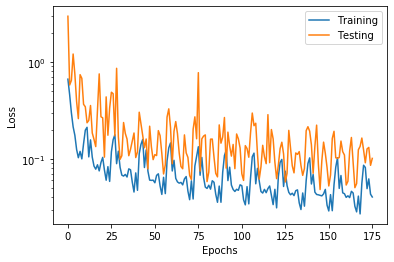

In [38]:
################################################################################
# %% PLOTTING LOSS CURVE
################################################################################

mp.semilogy(np.array(loss).flatten(), label='Training')
mp.semilogy(np.array(val_loss).flatten(), label='Testing')
mp.xlabel('Epochs')
mp.ylabel('Loss')
mp.legend()
mp.show()

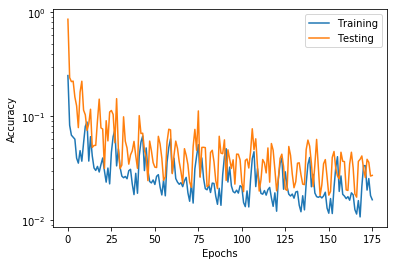

In [41]:
################################################################################
# %% PLOTTING ACCURACY CURVE
################################################################################

mp.plot(np.array(acc).flatten(), label='Training')
mp.plot(np.array(val_acc).flatten(), label='Testing')
mp.xlabel('Epochs')
mp.ylabel('Accuracy')
mp.legend()
mp.show()

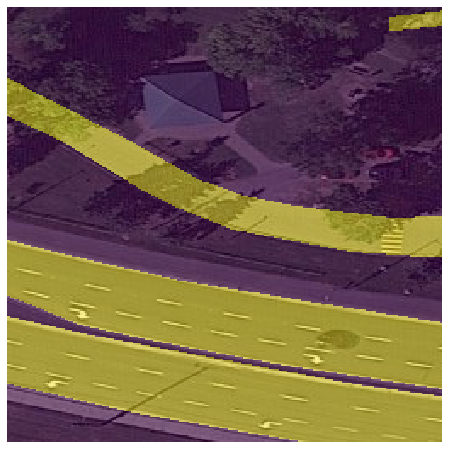

In [35]:
################################################################################
# %% PLOTTING BASE TRUTH
################################################################################

fig = mp.figure(figsize=(8,8))

id = 879

mp.imshow(X_test[id,:,:,:])
mp.imshow(y_test[id,:,:,0], alpha=0.5)
mp.axis('off')
mp.show()

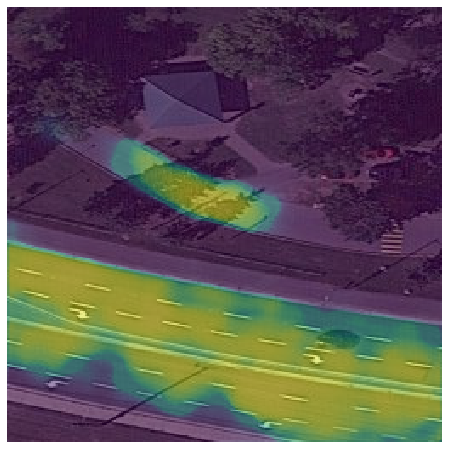

In [36]:
################################################################################
# %% PLOTTING PREDICTION ON TRAINING DATA
################################################################################

fig = mp.figure(figsize=(8,8))

X_pred = X_test[id]
X_pred = X_pred[np.newaxis]
y_pred = model.predict(X_pred)

mp.imshow(X_pred[0])
mp.imshow(y_pred[0, :, :, 0], alpha=0.5)
mp.axis('off')
mp.show()

In [0]:
################################################################################
# %% SAVE HISTORY TO CSV FOR FURTHER PROCESSING
################################################################################

hist = pd.DataFrame()
hist['loss'] = np.array(loss).flatten()
hist['val_loss'] = np.array(val_loss).flatten()
hist['acc'] = np.array(acc).flatten()
hist['val_acc'] = np.array(val_acc).flatten()

hist.to_csv('drive/My Drive/Data/hist96.csv')